<a href="https://colab.research.google.com/github/aCStandke/GAN_Models/blob/main/DeepConvolutionalGan(DCGAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Convolutional GAN (DCGAN)

Implementation of the Deep Convolutional GAN as detailed in Unsurpervised Representation Learning with Deep Convolutional Generative Adversaial Networks, [DCGAN](https://arxiv.rg/abs/15511.06434) and detailed in page 196 of the book Advanced Deep Learning with Python 



In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import fashion_mnist
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Dropout, Input, Dense, Reshape, Flatten
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import adam_v2

# Generator


In [2]:
# function that builds the generator
def build_generator(latent_input):
  model = Sequential([
                      # first fully connected layer to take in 1D latent vector of the generator 
                      Dense(7*7*256, use_bias=False, input_shape=latent_input.shape[1:]),
                      # applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
                      BatchNormalization(), 
                      LeakyReLU(), 
                      Reshape((7, 7, 256)),
                      # first layer of upsampeling(i.e. deconvolution) of the 1D latent vector/input  
                      Conv2DTranspose(filters=128, kernel_size=(5,5), strides=(1,1), padding='same', use_bias=False), 
                      BatchNormalization(), 
                      LeakyReLU(), 
                      # second layer of upsampeling(i.e. deconvolution) in which the volume depth is reduced
                      Conv2DTranspose(filters=64, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False), 
                      BatchNormalization(), 
                      LeakyReLU(), 
                      # third layer upsampeling(i.e. deconvolution) in which the volume depth is reduced
                      Conv2DTranspose(filters=1, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'), 

  ])

  # forward propogation of model
  generated = model(latent_input)
  return Model(z, generated)

# Discriminator

In [3]:
def build_discriminator():
  model = Sequential([
                     # first layers of discriminator network
                     Conv2D(filters=64, kernel_size=(5, 5), strides=(2,2), padding='same', input_shape = (28, 28, 1)),
                     LeakyReLU(),
                     Dropout(0.3), 
                     # second layers of discriminator network
                     Conv2D(filters=128, kernel_size=(5, 5), strides=(2,2), padding='same'),
                     LeakyReLU(),
                     Dropout(0.3),
                     Flatten(), 
                     Dense(1, activation='sigmoid'),                   
                    ])
  image = Input(shape=(28, 28, 1))
  output = model(image)
  return Model(image, output)

# Train Function

In [4]:
def train(generator, discriminator, combined, steps, batch_size):
  # loading the dataset
  (x_train, _), _ = fashion_mnist.load_data()
  # Rescale in [-1,1] interval
  x_train = (x_train.astype(np.float32)-127.5)/127.5
  x_train = np.expand_dims(x_train, axis=-1)
  # Discriminator ground truths for real and fake images
  real = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  latent_dim = generator.input_shape[1]

  for step in range(steps):
    # first train the discriminator

      # select a random batch of real images from the uninform distribution
      real_images = x_train[np.random.randint(0, x_train.shape[0], batch_size)]

      # generate a random batch of noise from the normal distribution for the generator 
      noise = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))

      # generate a bath of new images using the generator
      generated_images = generator.predict(noise)

      # discriminator loss on real images
      discriminator_real_loss = discriminator.train_on_batch(real_images, real)
      # discriminator loss on fake images
      discriminator_fake_loss = discriminator.train_on_batch(generated_images, fake)
      # discriminator total loss
      discriminator_loss = 0.5 * np.add(discriminator_real_loss, discriminator_fake_loss)

    # Second train the generator

      # generate latent vector z from the normal distribution
      noise = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
      # generator loss: As noted in the book the real images are combined with the latent vector to maximize the discriminator loss
      generator_loss = combined.train_on_batch(noise, real)

      # Display progress
      print("%d [Discriminator loss: %.4f%%, acc.: %.2f%%] [Generator loss: %.4f%%]" % (step, discriminator_loss[0], 100*discriminator_loss[1], generator_loss))
      

# Plot Generated Images

In [5]:
def plot_generated_images(generator):
  n = 10
  image_size = 28

  # big array containing all images
  figure = np.zeros((image_size * n, image_size* n))

  latent_dim = generator.input_shape[1]

  # 100 latent vectors sampled from a normal distribution
  noise = np.random.normal(loc=0, scale=1, size=(n * n, latent_dim)) 

  # generate the images 
  generated_images = generator.predict(noise)

  # fill the big array with images
  for i in range(n):
     for j in range(n):
       slice_i = slice(i*image_size, (i+1)*image_size)
       slice_j = slice(j*image_size, (j+1)*image_size)

  # plot the results
  plt.figure(figsize=(6, 5))
  plt.axis('off')
  plt.imshow(figure, cmap='gray', vmin=0, vmax=255)
  plt.show()

0 [Discriminator loss: 0.7005%, acc.: 25.50%] [Generator loss: 0.6759%]
1 [Discriminator loss: 0.6540%, acc.: 49.00%] [Generator loss: 0.6176%]
2 [Discriminator loss: 0.6090%, acc.: 50.00%] [Generator loss: 0.5390%]
3 [Discriminator loss: 0.5658%, acc.: 50.00%] [Generator loss: 0.4532%]
4 [Discriminator loss: 0.5324%, acc.: 50.00%] [Generator loss: 0.3565%]
5 [Discriminator loss: 0.4874%, acc.: 50.00%] [Generator loss: 0.2645%]
6 [Discriminator loss: 0.4520%, acc.: 52.00%] [Generator loss: 0.1988%]
7 [Discriminator loss: 0.4269%, acc.: 73.00%] [Generator loss: 0.1435%]
8 [Discriminator loss: 0.4041%, acc.: 94.50%] [Generator loss: 0.1030%]
9 [Discriminator loss: 0.3864%, acc.: 98.00%] [Generator loss: 0.0757%]
10 [Discriminator loss: 0.3773%, acc.: 92.00%] [Generator loss: 0.0557%]
11 [Discriminator loss: 0.3845%, acc.: 73.50%] [Generator loss: 0.0441%]
12 [Discriminator loss: 0.3827%, acc.: 53.50%] [Generator loss: 0.0376%]
13 [Discriminator loss: 0.3989%, acc.: 50.50%] [Generator los

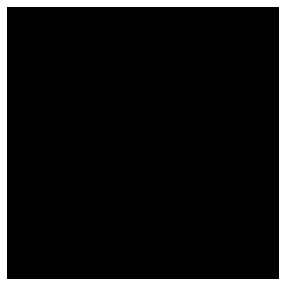

In [6]:
latent_dim = 64

# build the generator
z = Input(shape=(latent_dim))
generator = build_generator(z)
generated_image = generator(z)

optimizer = adam_v2.Adam(learning_rate=0.0002, beta_1=0.5)

# build the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Key!!: only training the generator for the combined model
discriminator.trainable = False

# discriminator deciding if image is fake or real
real_or_fake = discriminator(generated_image)

# Key!!: stacking the generator and discriminator in a combined model, and then training the generator
combined = Model(z, real_or_fake)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
train(generator, discriminator, combined, steps=25, batch_size=100)

# calling plot to see what images the generator has created from the fashion dataset
plot_generated_images(generator)